In [1]:
import functools
import itertools
import modelgym
import numpy as np
import os
import pandas as pd

from collections import OrderedDict


from modelgym.tracker import ProgressTrackerFile
from modelgym.trainer import Trainer
from modelgym.util import split_and_preprocess
from modelgym.util import TASK_CLASSIFICATION


from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

/opt/conda/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We will be trying to working with <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">Breast Cancer Wisconsin (Diagnostic) Data Set</a>

First, let's define some parameters.

In [2]:
# 20% of our dataset will be used to final evaluation and model comparisson
TEST_SIZE = 0.2
# ???
N_CV_SPLITS = 3

# ???
N_ESTIMATORS = 1000
# ???
N_PROBES = 100         

# We are using tree structured parzen estimator for hyperparameter optimization
# Another option is 'random'
OPTIMIZER = 'tpe'

## Dataset

Then, let's load the dataset itself

In [3]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)

Splitting the code into train and test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

This code is used to transform data to inner modelgym format. For example, it would transform categorial features, if we had any.

In [5]:
cv_pairs, (dtrain, dtest) = split_and_preprocess(X_train.copy(), y_train, 
                                                 X_test.copy(), y_test, 
                                                 cat_cols=[], n_splits=N_CV_SPLITS)

## Setup
We will train and compare <a href="https://xgboost.readthedocs.io/en/latest/">xgboost</a>,
<a href="https://github.com/Microsoft/LightGBM">lightgbm</a> and <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html"> random forest </a>

In [6]:
CANDIDATES = OrderedDict([
    ('XGBoost', modelgym.XGBModel), 
    ('LightGBM', modelgym.LGBModel),
    ('RandomForestClassifier', modelgym.RFModel)
])

We will save intermediate results in `results` directory

`config_key` will just be used in saved files names

In [7]:
RESULTS_DIR = "results"
tracker_factory = functools.partial(ProgressTrackerFile, RESULTS_DIR, config_key='example')
trackers = {name: tracker_factory(model_name=name) for name in CANDIDATES}

We will compare our custom metric -- roc auc in the end of training

In [8]:
custom_metric = {'roc_auc': roc_auc_score}

## Training
Here comes our trainer

In [9]:
trainer = Trainer(opt_evals=N_PROBES, n_estimators=N_ESTIMATORS)

In [10]:
def gym_training(trainer, model, tracker, cv_pairs, dtrain, dtest, mode, custom_metric):
    # these keys will be used later to retrieve best model from tracker
    cv_key = mode + "_cv"
    test_key = mode + "_test"
    
    if mode == "default":
        # Training default model on cross validation
        cv_metrics = trainer.crossval_fit_eval(model, cv_pairs, verbose=False)
        
    elif mode == "tuned":
        # Tuning hyperparameters and training model on cross validation
        cv_metrics = trainer.crossval_optimize_params(model, cv_pairs, algo_name=OPTIMIZER, tracker=tracker,
                                                      verbose=False)

    #  Saving results and (in case of tuned mode) best parameters
    tracker._update_state({cv_key: cv_metrics})

    # Fitting model on whole train data and evaluating metrics on test data
    test_metrics = trainer.fit_eval(model, dtrain, dtest,
                                    cv_metrics['params'],
                                    cv_metrics['best_n_estimators'],
                                    custom_metric=custom_metric)
    # Saving progress
    tracker._update_state({test_key: test_metrics})

In [11]:
for model_class in CANDIDATES.values():
    model = model_class(TASK_CLASSIFICATION)
    name = model.get_name()
    tracker = trackers[name]
    gym_training(trainer, model, tracker, cv_pairs, dtrain, dtest, 'default', custom_metric)
    gym_training(trainer, model, tracker, cv_pairs, dtrain, dtest, 'tuned', custom_metric)

    trackers[name].save_state()

saved state to results/tracker_example_XGBoost.pickle
saved state to results/tracker_example_XGBoost.pickle
saved state to results/tracker_example_XGBoost.pickle
saved state to results/tracker_example_XGBoost.pickle
saved state to results/tracker_example_XGBoost.pickle
saved state to results/tracker_example_XGBoost.pickle
saved state to results/tracker_example_XGBoost.pickle
saved state to results/tracker_example_XGBoost.pickle
saved state to results/tracker_example_XGBoost.pickle
saved state to results/tracker_example_XGBoost.pickle
saved state to results/tracker_example_XGBoost.pickle
saved state to results/tracker_example_LightGBM.pickle
saved state to results/tracker_example_LightGBM.pickle
saved state to results/tracker_example_LightGBM.pickle
saved state to results/tracker_example_LightGBM.pickle
saved state to results/tracker_example_LightGBM.pickle
saved state to results/tracker_example_LightGBM.pickle
saved state to results/tracker_example_LightGBM.pickle
saved state to result

## Compare
Let's now compare our 

The following cell just collects all the states of different models from trackers

In [12]:
full_results = {}
for i in CANDIDATES.keys():
    if i in trackers:
        tracker = trackers[i]
    else:
        tracker = tracker_factory(model_name=i)
        tracker.load_state()
    full_results.update({i:{'tuned': tracker.state['tuned_test'], 'default': tracker.state['default_test']}})

In [13]:
def format_result(result, diff):
    return '{:.6f} ({:+.2f}%)'.format(result, diff)

def print_results(test_results, index):
    if is_min_better:
        baseline = test_results.min()
    else:
        baseline = test_results.max()
    diff = 100 * test_results / baseline - 100
    test_results_formatted = \
        [[format_result(test_results[i, j], diff[i, j]) for j in range(2)] for i in range(len(index))]

    print(pd.DataFrame(test_results_formatted, columns=['default', 'tuned'], index=index))
    
def plot_results(test_results, index):
    full_names = ["%s %s" % (name, mode) for name in index for mode in ['default', 'tuned']]
    named_results = zip(full_names, test_results.flatten())

    sorted_results = sorted(named_results, key=lambda x: x[1], reverse=not is_min_better)
    
    xticks = ['%s\n%.5f' % (name, loss) for name, loss in sorted_results]

    pyplot.figure(figsize=(20, 7))
    pyplot.scatter(range(len(full_names)), list(zip(*sorted_results))[1], s=150)
    pyplot.xticks(range(len(full_names)), xticks, fontsize=15)
    pyplot.yticks(fontsize=12)
    pyplot.title('Comparison', fontsize=20)
    pyplot.ylabel(metric, fontsize=16)

def view_results(full_results, index, metric, is_min_better=True):
    test_results_list = [[result['default'][metric], result['tuned'][metric]] for result in full_results.values()]
    test_results = np.array(test_results_list)
    print_results(test_results, index)
    plot_results(test_results, index)

Populating the interactive namespace from numpy and matplotlib
                                  default              tuned
XGBoost                 0.979167 (-0.50%)  0.982308 (-0.18%)
LightGBM                0.984127 (+0.00%)  0.982474 (-0.17%)
RandomForestClassifier  0.946429 (-3.83%)  0.891865 (-9.38%)


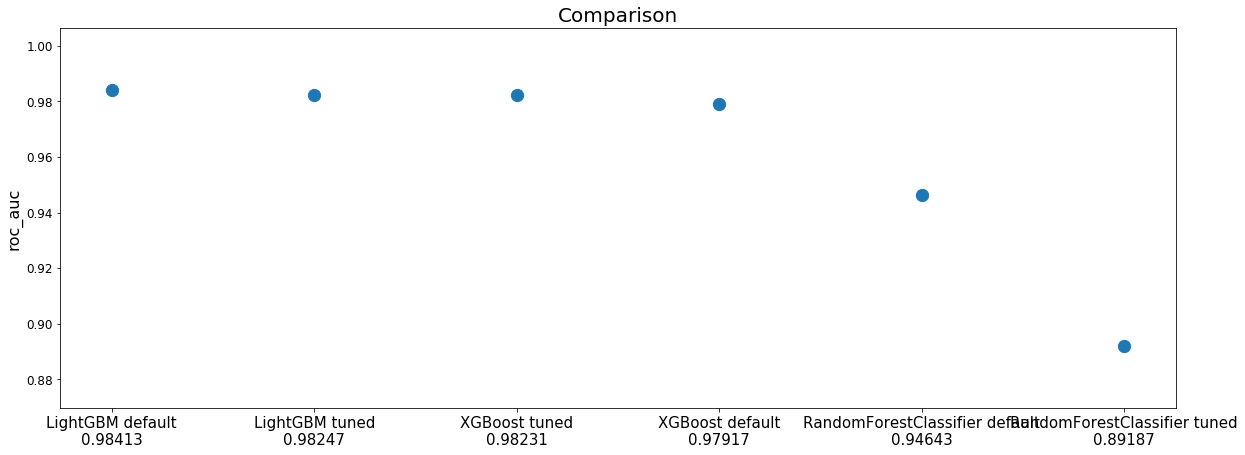

In [14]:
%pylab inline --no-import-all

metric = 'roc_auc'
is_min_better = False

view_results(full_results, CANDIDATES.keys(), metric, is_min_better=is_min_better)

# Compare models with stat test

We clearly see, that some models are better, than another. But is this difference significant or random?

Let's use the power of statistics!

* Compare that out tuned RF model difference from default is statistically significant:

In [15]:
default_rf_model = full_results['RandomForestClassifier']['default']['bst']
tuned_rf_model = full_results['RandomForestClassifier']['tuned']['bst']

print('Two models are different: {}, p-value {}'.format(
    *modelgym.util.compare_models_different(tuned_rf_model, default_rf_model, dtest)
))

Two models are different: False, p-value [[ 0.06388195]]


* Compare default LightGBM and default RF

In [16]:
default_lightGBM_model = full_results['LightGBM']['default']['bst']

print('Two models are different: {}, p-value {}'.format(
    *modelgym.util.compare_models_different(default_lightGBM_model, default_rf_model, dtest)
))

Two models are different: True, p-value [[ 0.01744166]]
